# **Exploratory Data Analysis**
After three notebooks we finally got the data in a position where it can be used to uncover insights. Since this project is focused on stations, we only needed the trip data to get the station data. However, it is possible that the trip data contains gems of insight. In this notebook we will explore the data that is in the trips and stations schema of the database. First we will perform some very basic exploratory analysis on the trip data and then we will do more in-depth analysis on the station data.

### **Connecting to the Database**

In [20]:
pip install psycopg2-binary;

  Using cached psycopg2_binary-2.8.6-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install s3fs

  Using cached botocore-1.19.52-py2.py3-none-any.whl (7.2 MB)
ERROR: boto3 1.17.34 has requirement botocore<1.21.0,>=1.20.34, but you'll have botocore 1.19.52 which is incompatible.
ERROR: awscli 1.19.34 has requirement botocore==1.20.34, but you'll have botocore 1.19.52 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.34
    Uninstalling botocore-1.20.34:
      Successfully uninstalled botocore-1.20.34
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install geopandas

  Using cached geopandas-0.9.0-py2.py3-none-any.whl (994 kB)
  Using cached Shapely-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (1.0 MB)
  Using cached Fiona-1.8.18-cp37-cp37m-manylinux1_x86_64.whl (14.8 MB)
  Using cached pyproj-3.0.1-cp37-cp37m-manylinux2010_x86_64.whl (6.5 MB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.1-py3-none-any.whl (7.1 kB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import psycopg2

In [32]:
# Put the password in 
PGHOST = 'tripdatabase2.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [33]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



<hr>

## **Basic Exploratory Analysis for Trips**
In this section we will do some basic analysis on the trip data for the different bike share services. Some queries do take a while to run so at the start of each subsection there are commented lines of code that can read in the saved query data from a file instead of querying the database. Uncomment and run the code and then skip the following cell block.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import s3fs
import sys

In [35]:
sys.path.append(os.path.join(os.getcwd(),'Data','Scripts'))
import Queries

In [36]:
# The S3 Bucket that will be used to store the data should be created beforehand
ACCESS_KEY_ID = ''
ACCESS_SECRET_KEY = ''

fs = s3fs.S3FileSystem(anon=False, key = ACCESS_KEY_ID, secret= ACCESS_SECRET_KEY)

In [37]:
services = ['bay', 'blue', 'capital', 'citi', 'divvy']

### **Trips Per Month Over the Years**

In [38]:
# trips_per_month = pd.read_csv('./Data/Queries/trips_per_month.csv')

<div align="center" class="alert alert-block alert-info">
    <b>Tip: If you don't want to wait for the following query, uncomment and run the above cell and skip the one below.</b>
</div>

In [209]:
trips_per_month = pd.DataFrame(columns= ['year_month', 'trips', 'service'])

for service in services:
    trip_per_month_query = f"""
            SELECT 
              DATE_TRUNC('month', starttime) as year_month, 
              COUNT(*) as trips, 
              '{service}' as service
            FROM trips.{service}_trip
            GROUP BY year_month
            ORDER BY year_month;
            """
    trips_per_month = trips_per_month.append(Queries.execute_query(conn, trip_per_month_query, to_frame=True))

trips_per_month.trips = trips_per_month.trips.astype('int32')
trips_per_month['year_month'] = trips_per_month['year_month'].apply(lambda x: x.strftime('%Y-%m'))

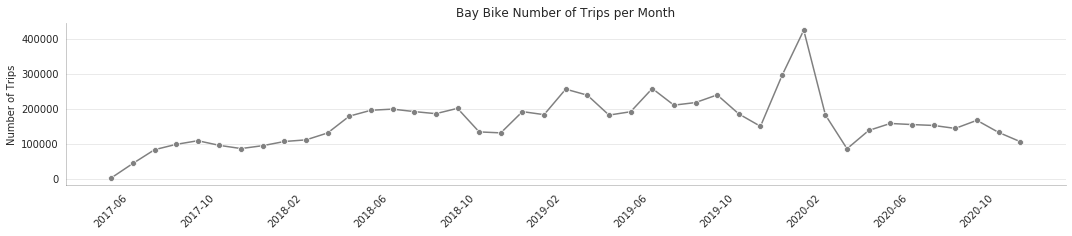

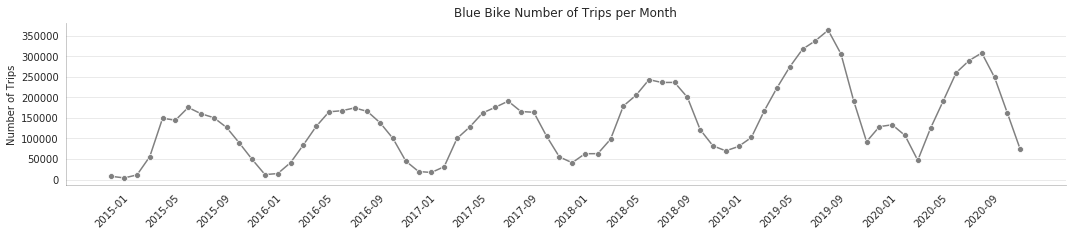

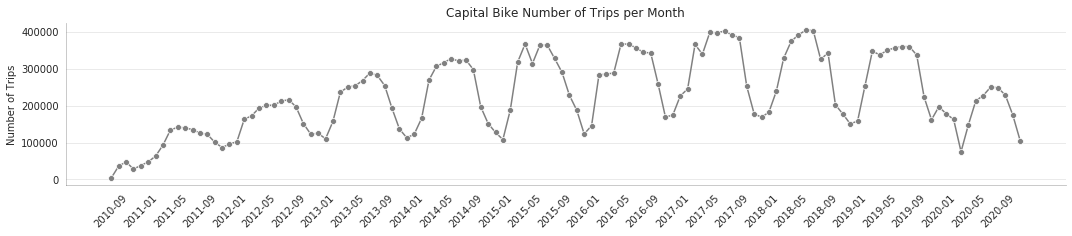

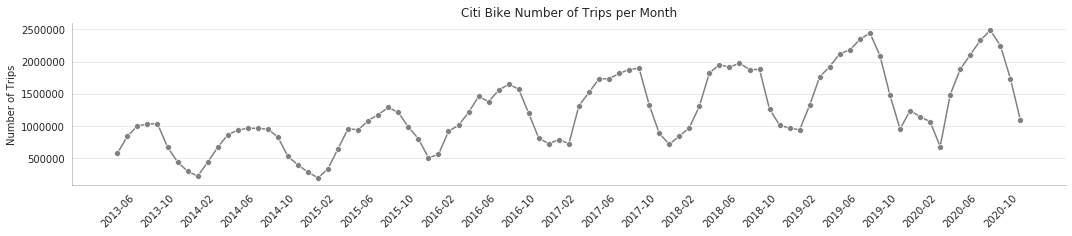

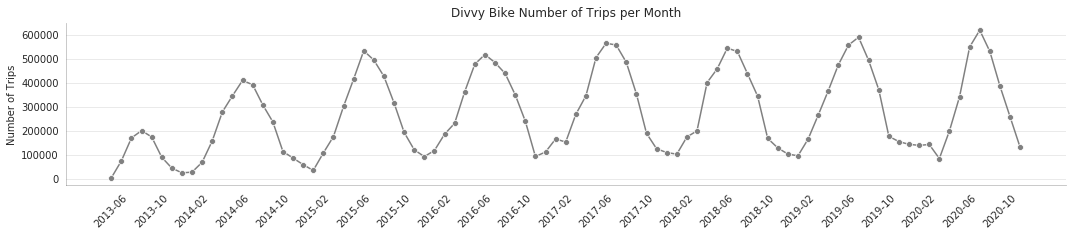

In [208]:
sns.set_style('white')

for service in services:
    subset = trips_per_month[trips_per_month.service==service]
   
    xticks_location = subset.index.tolist()[::4]
    xticks_labels = subset.year_month.tolist()[::4]
    
    ax = sns.relplot('year_month','trips', data= subset, kind='line', height=3, aspect = 5, color='grey', marker='o')
    plt.xticks(ticks=xticks_location, labels=xticks_labels, rotation=45);

    #g.set(xlabel = 'Year/Month', ylabel = "Number of Trips", title = service.title() + ' Trips')
    #g.set_xticklabels(rotation=45)
    plt.gca().spines['left'].set_alpha(0.3)
    plt.gca().spines['bottom'].set_alpha(0.3)
    
    plt.title(f"{service.title()} Bike Number of Trips per Month")

    plt.xlabel("")
    plt.ylabel("Number of Trips")

    plt.grid(axis='y', alpha=0.5)

<p style="text-align:center"> <b> Observations </b> </p>

<ol>
    <li style="margin: 10px 0">The number of trips taken throughout the year for each service, exccept BayWheels, ebbs and flows. An explanation for this may be the chnging of the seasons in those four cities (Boston, Washington D.C, New York City, Chicago) from winter to summer and back. Temperatures begin to rise into spring and reaches its heights in summer. The number of trips follow this pattern. When temperature drops going into winter the number of trips follow. BayWheels is located in the San Francisco area and the winter climate there is mild and rainy, more comparable to the spring climate in the other cities. 
    <li style="margin: 10px 0"> Prior to effects of COVID-19, over time, both the peaks and the troughs for the four services that have seasonality were gradually getting higher. Impling that the bike service is getting used more each year. Except in Chicago (Divvy), where both peaks and troughs appear to be relatively equal. 
    <li> In the first months of 2020 the number of trips had a massive drop off going into April instead of following its usual behavior of a relatively steady rise. The most likely cause of that was the impact that COVID-19 had on the cities, specifically the lockdowns that were being implemented.       
</ol>

**Project Extension: Maybe do a return analysis that looks at the correlation between the returns of the temperature and the number of trips. Similar to how you would compare the returns of different stocks to see if they are correlated.**

### **Trips Per Hour**

In [ ]:
# trips_per_hour = pd.read_csv('./Data/Queries/trips_per_hour.csv')

<div align="center" class="alert alert-block alert-info">
    <b>Tip: If you don't want to wait for the following query, uncomment and run the above cell and skip the one below.</b>
</div>

In [49]:
trips_per_hour = pd.DataFrame(columns = ['hour', 'trips', 'service'])

for service in services:
    trip_per_hour_query = f"""
            SELECT 
              EXTRACT(HOUR FROM starttime) as hour, 
              count(*) as trips, 
              '{service}' as service
            FROM trips.{service}_trip
            GROUP BY hour
            ORDER BY hour;
            """
    trips_per_hour = trips_per_hour.append(Queries.execute_query(conn, trip_per_hour_query, to_frame=True))

trips_per_hour.trips = trips_per_hour.trips.astype('int32')

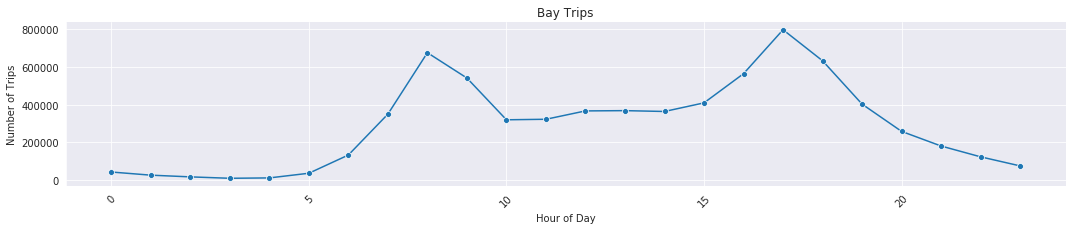

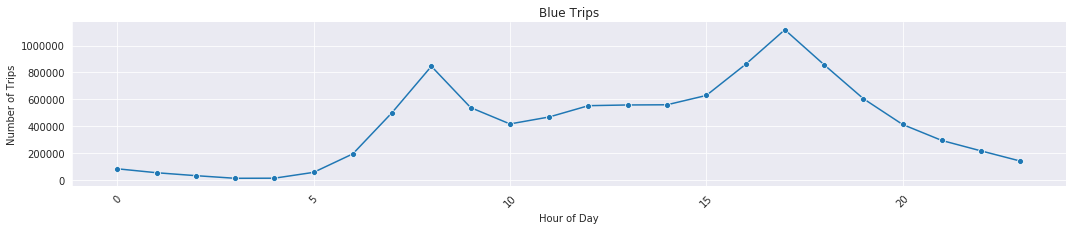

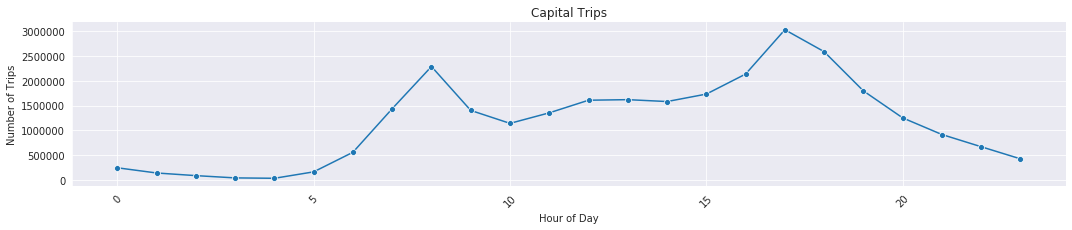

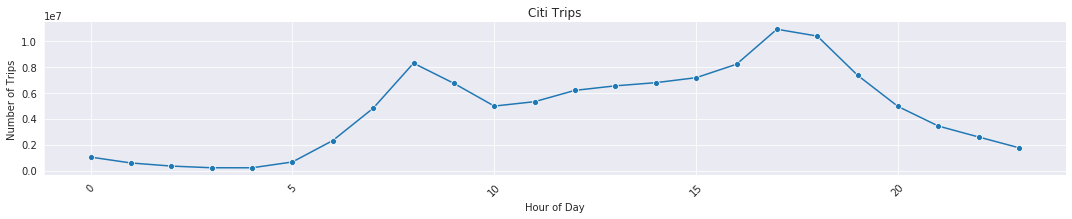

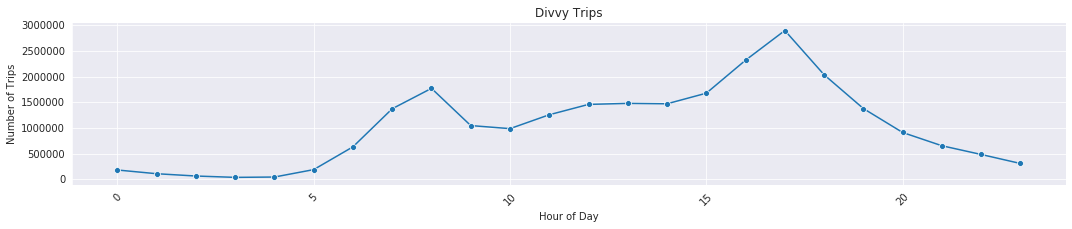

In [11]:
for service in services:
    g = sns.relplot('hour','trips', data= trips_per_hour[trips_per_hour.service==service], kind='line', height=3, aspect = 5, marker='o')
    
    g.set(xlabel = 'Hour of Day', ylabel = "Number of Trips", title = service.title() + ' Trips')
    g.set_xticklabels(rotation=45)

<p style="text-align:center"> <b>Daily Hour Pattern - Across all Services </b> </p>

<ol>
    <li> The # of trips begins to ramp up starting in the 6AM hour and hits its first peak during the 8AM hour.
    <li> From the 9AM to 3PM hours the number of trips seems to be stable.
    <li> After 3PM the # of trips begin to ramp up again starting in the 4PM hour and reaches daily highs during the 5/6PM hours.
    <li> After 5/6PM the # of trips slowly begins to taper off and the process repeats itself. 
</ol> 

The question then is: what's so special about 6-8AM and 4-6PM that causes the number of trips to increase? The answer might be Rush Hour. "Normally it happens twice every weekday; once in the morning and once in the afternoon or evening, the times during which the most people communte...Rush hour may be 6-10AM and 3-7PM...The frequency of public transport service is usually higher in the rush hour..."

https://en.wikipedia.org/wiki/Rush_hour

### **Trips Per Hour Conditional on the Day**

In [ ]:
# trips_per_hour_cond = pd.read_csv('./Data/Queries/trips_per_hour_cond.csv')

<div align="center" class="alert alert-block alert-info">
    <b>Tip: If you don't want to wait for the following query, uncomment and run the above cell and skip the one below.</b>
</div>

In [51]:
trips_per_hour_cond = pd.DataFrame(columns=['day','hour','trips', 'service'])
                                  
for service in services:
    trips_per_hour_query = f"""
            SELECT 
              EXTRACT(DOW FROM starttime) as day, 
              EXTRACT(HOUR FROM starttime) as hour, 
              count(*) as trips, 
              '{service}' as service
            FROM trips.{service}_trip
            GROUP BY day, hour
            ORDER BY day, hour;
            """
    trips_per_hour_cond = trips_per_hour_cond.append(Queries.execute_query(conn, trips_per_hour_query, to_frame=True))
                                  
trips_per_hour_cond = trips_per_hour_cond.astype({'trips':'int32', 'hour':'int32'})          

In [13]:
mapping = {
    0:'Sunday',
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday'
}
trip_per_hour_cond.day = trip_per_hour_cond.day.map(mapping)

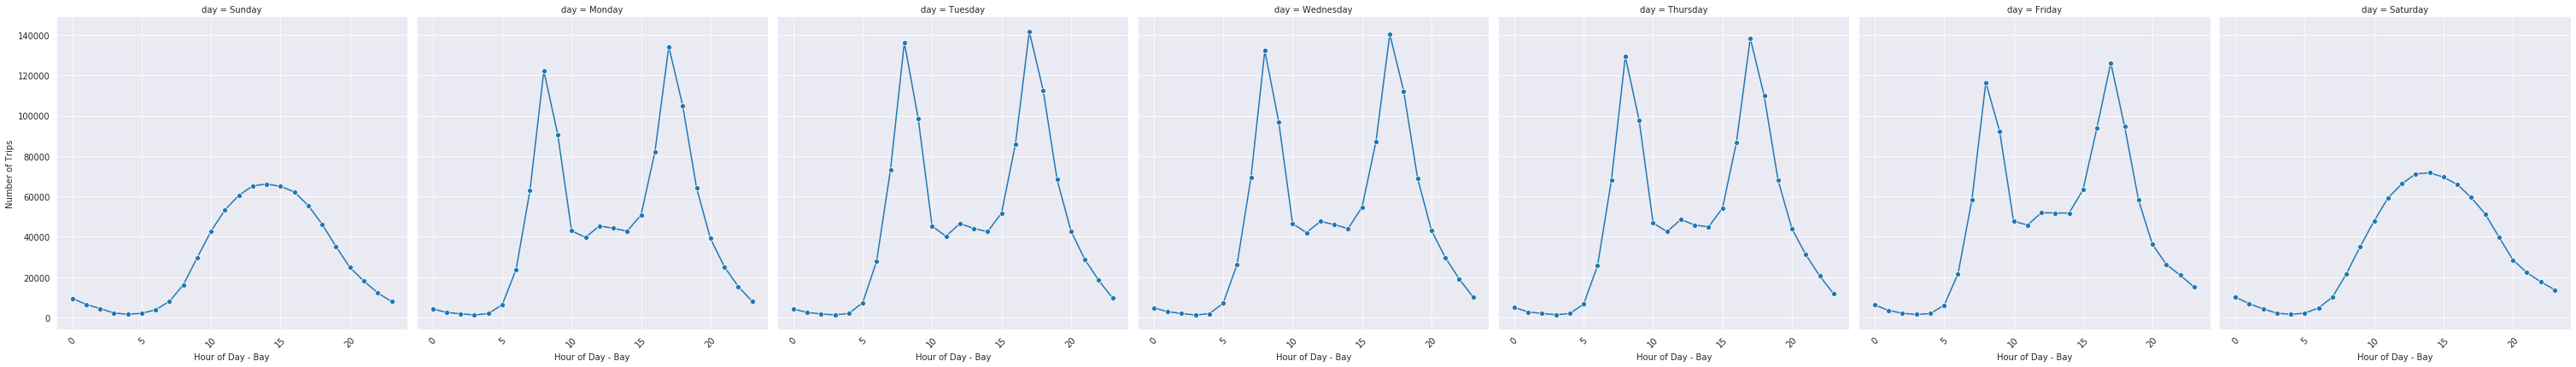

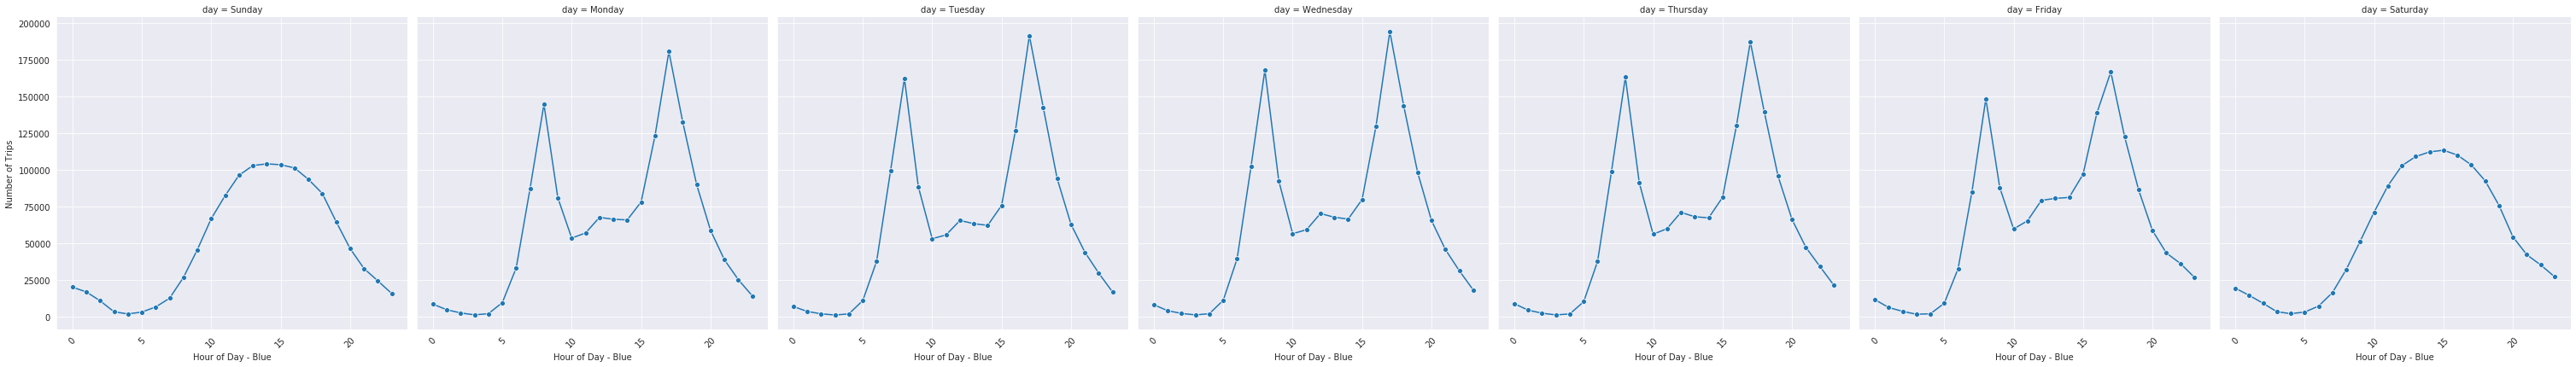

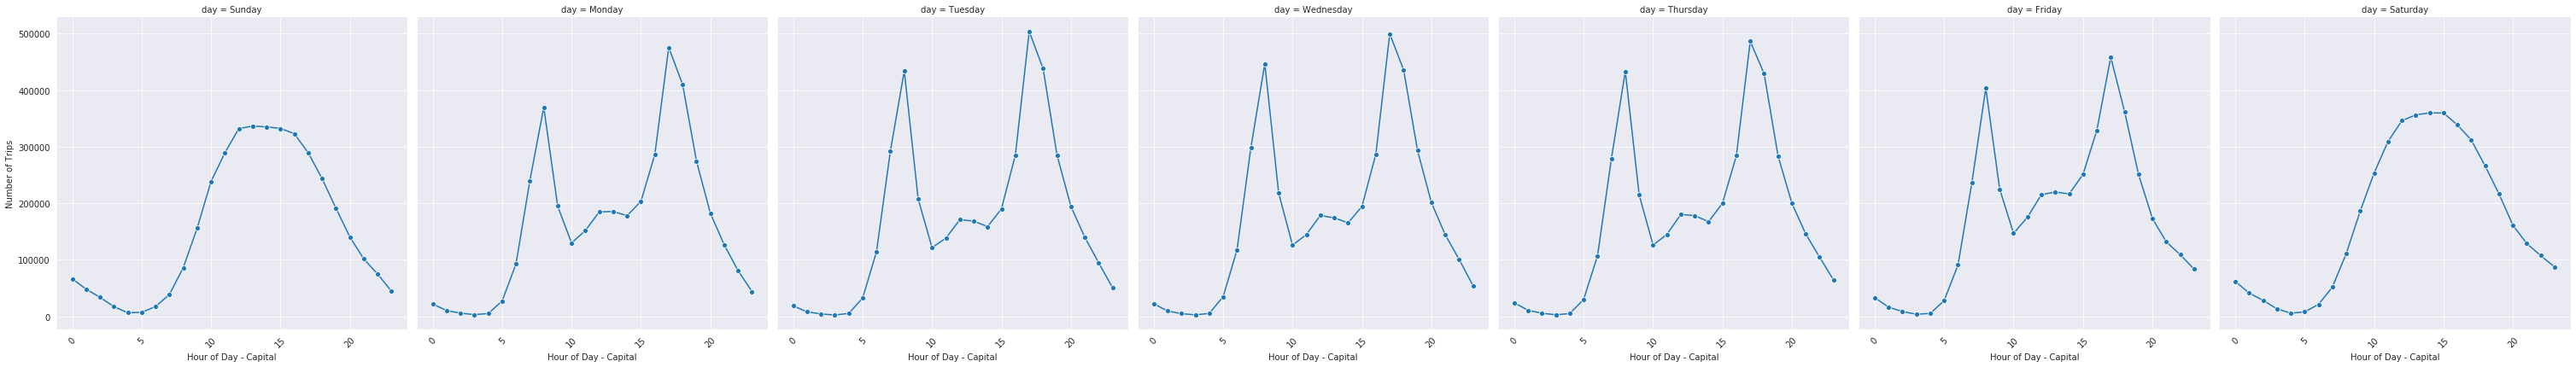

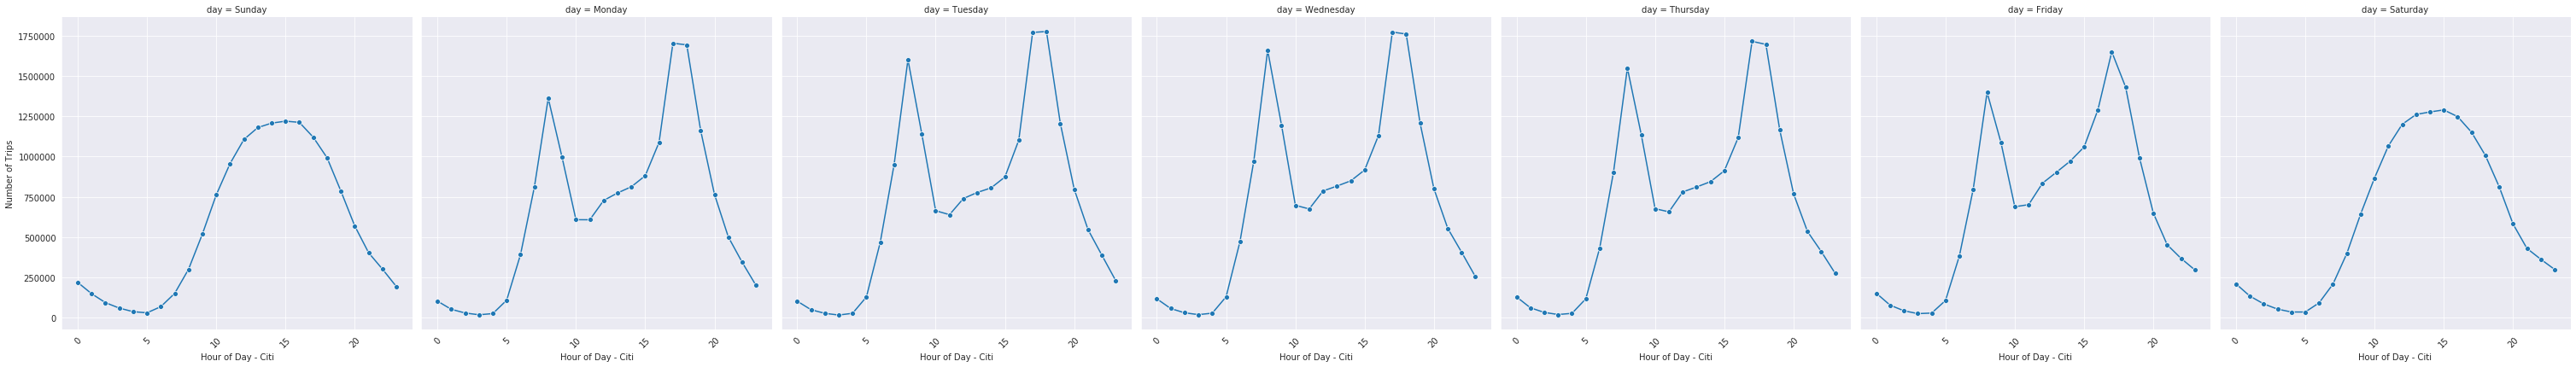

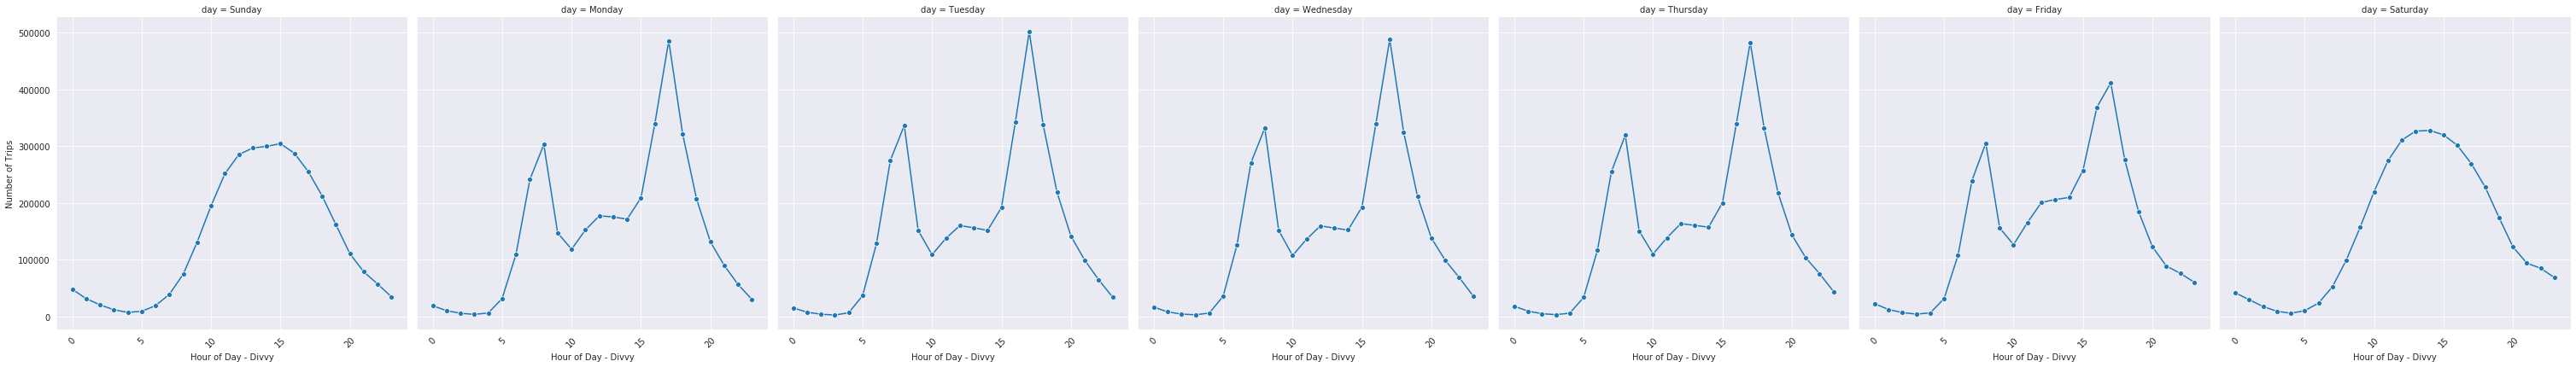

In [14]:
for service in services:
    g = sns.relplot('hour','trips', data= trip_per_hour_cond[trip_per_hour_cond.service==service], col='day', kind='line', height=6, aspect = 1, marker='o')
    
    g.set(xlabel = f'Hour of Day - {service.title()}', ylabel = "Number of Trips")
    g.set_xticklabels(rotation=45)

<p style="text-align:center"> <b> Hour Pattern by Day of Week - Across All Stations </b> </p>

<ol>
    <li> The weekdays tend to have a similar structure and the weekends have a similar structure
    <li> The weekends don't have that sharp rises and declines that the weekdays do. The # of trips gradually rises and then gradually falls. 
</ol>

When it comes to CitiBike, the absence of a third peak on Friday stands out from the other weekdays. Normally there are a high number of trips during the 5 and 6 pm hours before the decline, but on Friday there is only one peak at 5pm. If peaks in trips represent when people are traveling to and from work, it seems that people don't waste anytime leaving work on Friday evening. 
<hr>

## **Station Growth**
Let's look at how the number of Bike Share stations change within an ecosytem over time by looking at how many stations are active in the ecosystem at year end. We need to look at how many stations were added within the year and how many stations were removed.

In [10]:
station_growth = pd.DataFrame(data = {'year': ['2010-01-01', '2011-01-01', '2012-01-01',
                                      '2013-01-01', '2014-01-01', '2015-01-01',
                                      '2016-01-01', '2017-01-01', '2018-01-01',
                                      '2019-01-01', '2020-01-01']})

station_growth.year = pd.to_datetime(station_growth.year, infer_datetime_format = True)

for service in services:   
    df = Queries.station_growth(conn, service)
    station_growth = station_growth.merge(df, how='left', on='year')

station_growth.set_index('year',inplace=True)
station_growth.fillna(0, inplace=True)
station_growth = station_growth.astype('int32')

<a id="Station_Growth"> </a>

In [11]:
station_growth

,bay_added,bay_total,blue_added,blue_total,capital_added,capital_total,citi_added,citi_total,divvy_added,divvy_total
year,,,,,,,,,,
2010-01-01,0,0,0,0,106,106,0,0,0,0
2011-01-01,0,0,0,0,38,144,0,0,0,0
2012-01-01,0,0,0,0,50,194,0,0,0,0
2013-01-01,0,0,0,0,111,305,335,335,300,300
2014-01-01,0,0,0,0,41,346,0,0,0,0
2015-01-01,0,0,154,154,11,357,144,479,175,475
2016-01-01,0,0,33,187,77,434,145,624,105,580
2017-01-01,269,269,11,198,52,486,153,777,5,585
2018-01-01,55,324,71,269,42,528,11,788,18,603


<hr>

## **Popularity Contest**
We will look at which stations are the most popular for each service by year, in terms of all the trips that they are invovled in regardless of whether it was a start or an end.

In [39]:
# most_popular_3 = pd.read_csv('./Data/Queries/most_popular_3.csv')

<div align="center" class="alert alert-block alert-info">
    <b>Tip: If you don't want to wait for the following query, uncomment and run the above cell and skip the one below.</b>
</div>

In [ ]:
most_popular_3 = pd.DataFrame(columns=['year','stationid', 'station', 'startpoints','endpoints', 'total_points', 'ranking', 'service'])

for service in services:
    df = Queries.n_popular_stations(conn, service, n=3, ranking = 'total')
    most_popular_3 = most_popular_3.append(df)

In [40]:
most_popular_3.groupby('ranking').get_group(1)

,Unnamed: 0,year,stationid,station,startpoints,endpoints,total_points,ranking,service
0,0,2017-01-01,15,San Francisco Ferry Building (Harry Bridges Pl...,15187,17109,32296,1,bay
3,3,2018-01-01,67,San Francisco Caltrain Station 2 (Townsend St...,37616,50000,87616,1,bay
6,6,2019-01-01,NaN,NaN,80121,82339,162460,1,bay
9,9,2020-01-01,NaN,NaN,874394,898057,1772451,1,bay
12,0,2015-01-01,22,South Station - 700 Atlantic Ave.,30798,31284,62082,1,blue
15,3,2016-01-01,67,MIT at Mass Ave / Amherst St,35654,36107,71761,1,blue
18,6,2017-01-01,67,MIT at Mass Ave / Amherst St,42319,42442,84761,1,blue
21,9,2018-01-01,67,MIT at Mass Ave / Amherst St,53846,49635,103481,1,blue
24,12,2019-01-01,67,MIT at Mass Ave / Amherst St,61055,56986,118041,1,blue
27,15,2020-01-01,68,Central Square at Mass Ave / Essex St,34220,35158,69378,1,blue


BayWheels, CapitalBike, and DivvyBike introduced the idea of 'floating bikes' in 2018-06, 2020-06, and 2020-07 respectively. The idea is that riders don't have to pickup/dropoff a bike at a designated station and can unlock/lock the bike on any public bike rack. When riders are given that option, they take advantage of it. In 2020, floating bike based rides were the most popular 'station' for all three service. This doesn't prove that riders use the float feature more than stations, in fact that isn't true. It only proves that the floating bike option is something that is desirable to riders and would be used if a bikeshare service started implementing it into their ecosystem.


<div align="center" class="alert alert-block alert-warning">
    <p style="text-align:center;font-style:italic"> There are infinitely many floating stations and they are all used to come up with the total for the category, meaning it is an aggregate. Therefore comparing that aggregate column to a single station is unfair. If we were to sum up the totals for all stations, comparing an aggregate to an aggregate, then rides with designated stations would win by a landslide. </p>
</div>


### **Old Stations vs. New Station?**
Were the stations that took the # 1 spot from a reigning champion new stations or were they old stations that got popular?

In [24]:
cols = ['stationid', 'name', 'zipcode', 'birth', 'death']

In [25]:
blue_overtake_query = """
        SELECT * 
        FROM stations.blue_station
        WHERE stationid IN ('22.0','67.0','68.0');
        """

blue_overtake = Queries.execute_query(conn, blue_overtake_query, to_frame=True)
blue_overtake[cols]

,stationid,name,zipcode,birth,death
0,22.0,South Station - 700 Atlantic Ave,2110,2015-04-17,None
1,67.0,MIT at Mass Ave / Amherst St,2139,2015-01-01,None
2,68.0,Central Square at Mass Ave / Essex St,2139,2015-01-01,None


South Station was born 4 months after the MIT and Central Square station and stil took the number spot for 2015. However, MIT at Mass Ave. stayed the champion up unitl 2020. So what happened? The MIT station is in the vicinity of the college and when the college slowed down due to COVID-19, I'm guessing so did traffic to that station. However, Central Square is only a couple blocks away in the same zipcode. I suspect that the 02139 is a high traffic zipcode. 

In [26]:
capital_overtake_query = """
        SELECT * 
        FROM stations.capital_station
        WHERE stationid IN ('31200.0','31623.0');
        """
capital_overtake = Queries.execute_query(conn, capital_overtake_query, to_frame=True)
capital_overtake[cols]

,stationid,name,zipcode,birth,death
0,31200.0,Massachusetts Ave & Dupont Circle NW,20036,2010-09-20,None
1,31623.0,Columbus Circle / Union Station,20002,2010-10-26,None


The two stations were born around the same time, but for some reason in 2014 Columbus Circle gained and maintained popularity. In fact, many stations over took Massachusetts Ave and over the years it slowly moved out of the top 5.

In [29]:
capital_overtake_query = """
        SELECT * 
        FROM stations.citi_station
        WHERE stationid IN ('497.0', '521.0', '519.0', '426.0');
        """
citi_overtake = Queries.execute_query(conn, capital_overtake_query, to_frame=True)
citi_overtake[cols]

,stationid,name,zipcode,birth,death
0,426.0,West St & Chambers St,10282,2013-06-01,NaT
1,521.0,8 Ave & W 31 St,10199,2013-06-01,2016-05-17
2,497.0,E 17 St & Broadway,10003,2013-06-01,NaT
3,519.0,Pershing Square North,10168,2013-06-01,NaT


All stations were born at the same time and the only one that was discontinued was 8 Ave. When it comes to 2020, West St might only be number 1, once again, due to COVID-19. The reason that I say this is because Pershing Square is across the street from Grand Central Terminal and three blocks away from Times Square, which are ultra high traffic areas, except when the city is shutdown. 

### **Most Popular Stations of All Time**
To compare across all services we have to look at the number of trips in a station relative to the number of trips in that year. Otherwise, CitiBike would win all the time.

In [42]:
# trips_per_year = pd.read_csv('./Data/Queries/trips_per_year.csv')

<div align="center" class="alert alert-block alert-info">
    <b>Tip: If you don't want to wait for the following query, uncomment and run the above cell and skip the one below.</b>
</div>

In [14]:
trips_per_year = pd.DataFrame(columns= ['year', 'trips', 'service'])

for service in services:
    trip_per_year_query = f"""
            SELECT 
              DATE_TRUNC('year', starttime) as year, 
              COUNT(*) as trips, 
              '{service}' as service
            FROM trips.{service}_trip
            GROUP BY year
            ORDER BY year;
            """
    trips_per_year = trips_per_year.append(Queries.execute_query(conn, trip_per_year_query, to_frame=True))

trips_per_year.trips = trips_per_year.trips.astype('int32')

In [28]:
most_popular_ratio = pd.merge(most_popular_3, trips_per_year, how='left', on=['year', 'service'])
most_popular_ratio.head()

,year,stationid,station,startpoints,endpoints,total_points,ranking,service,trips
0,2017-01-01,15,San Francisco Ferry Building (Harry Bridges Pl...,15187,17109,32296,1,bay,519699
1,2017-01-01,6,The Embarcadero at Sansome St,13664,16531,30195,2,bay,519699
2,2017-01-01,30,San Francisco Caltrain (Townsend St at 4th St),12546,17378,29924,3,bay,519699
3,2018-01-01,67,San Francisco Caltrain Station 2 (Townsend St...,37616,50000,87616,1,bay,1863715
4,2018-01-01,15,San Francisco Ferry Building (Harry Bridges Pl...,38461,44113,82574,2,bay,1863715


In [33]:
most_popular_ratio['relative_total_points'] = most_popular_ratio.total_points/most_popular_ratio.trips

In [55]:
most_popular_ratio = most_popular_ratio.sort_values(by='relative_total_points', ascending = False).reset_index(drop=True)

In [56]:
most_popular_ratio.head(10)

,year,stationid,station,startpoints,endpoints,total_points,ranking,service,trips,relative_total_points
0,2020-01-01,,,874394,898057,1772451,1,bay,2143905,0.82674
1,2010-01-01,31200,Massachusetts Ave & Dupont Circle NW,5093,5603,10696,1,capital,115595,0.09253
2,2011-01-01,31200,Massachusetts Ave & Dupont Circle NW,49092,53908,103000,1,capital,1226758,0.0839611
3,2020-01-01,-1.0,,84544,97099,181643,1,capital,2209060,0.0822264
4,2010-01-01,31201,15th & P St NW,3749,4047,7796,2,capital,115595,0.0674424
5,2010-01-01,31104,Adams Mill & Columbia Rd NW,4160,3535,7695,3,capital,115595,0.0665686
6,2019-01-01,,,80121,82339,162460,1,bay,2506852,0.0648064
7,2017-01-01,67,MIT at Mass Ave / Amherst St,42319,42442,84761,1,blue,1313718,0.0645199
8,2017-01-01,15,San Francisco Ferry Building (Harry Bridges Pl...,15187,17109,32296,1,bay,519699,0.0621437
9,2012-01-01,31200,Massachusetts Ave & Dupont Circle NW,58069,64797,122866,1,capital,2028896,0.0605581


The percentage of trips taken using a floating bike in BayWheels hit an astronomical value of 86%. I believe that COVID-19 played a role in the overall reduction of trips in general, but I am not confident that the same reasoning can be applied to the massive spike in floating bike use. 

One thing that I can think of is that because the floating bikes can be parked anywhere, combined with the state locking down, the people that WERE using the bikeshare were going directly to where they needed to go, parked the bike, picked up the same bike, then parked it very close to their apartment, and then repeated the process with the same bike for another trip. <b>This explanation is really grasping at straws and there isn't any data to back it up.<b>

Other than floating stations, "old-school" CapitalBike stations (2010-2012) appeared 5 times in the top 10 stations. Why? If we look back at our station growth table , in those years CapitalBike had 106, 144, and 194 stations in its ecosystem, respectively. Those numbers represent some of the lowest numbers of stations in an ecosystem at any given time. Which such a low number of stations, stations that are more popular will be able to capture more of the rider market, because the system isn't "decentralized". Which is why CitiBike, makes it appearances in 80th - 110th (out of 111) place. From its inception CitiBike had the most stations out of every ecosystem and no other service could keep up with its growth. CitiBike has nearly double the number of stations as its closet competitor. You can say that the CitiBike ecosytem is "decentralized"

[<p style="text-align:right"> Link to Station Growth Table </p>](#Station_Growth) 
<hr>

## **Inter Zipcode Travel**
For an expansion into a new area, is it important to start with multiple zip codes or can you stay within one?

In [ ]:
# inter_zipcode = pd.read_csv('./Data/Queries/inter_zipcode.csv')

<div align="center" class="alert alert-block alert-info">
    <b>Tip: If you don't want to wait for the following query, uncomment and run the above cell and skip the one below.</b>
</div>

In [58]:
inter_zipcode = pd.DataFrame(columns = ['year', 'percent_inter_travel', 'service'])

for service in services:
    if service in ['bay','divvy']:
        inter_zipcode = inter_zipcode.append(Queries.inter_zipcode_travel(conn, service, id_type='VARCHAR'))
    else:
        inter_zipcode = inter_zipcode.append(Queries.inter_zipcode_travel(conn, service))

inter_zipcode.percent_inter_travel = inter_zipcode.percent_inter_travel.astype('int32')

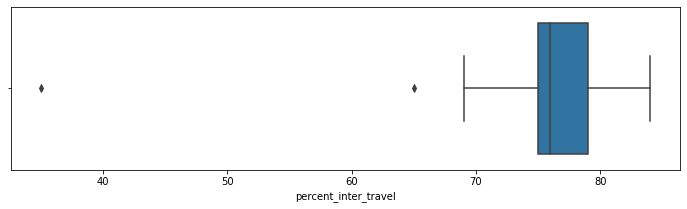

In [73]:
fig, ax = plt.subplots(figsize=(12,3))
sns.boxplot(x='percent_inter_travel', data=inter_zipcode, ax=ax, orient='h');

It is extremely important that stations be set up in multiple zipcodes when planning an expansion effort. From the plot, we see that the majority of trips taken by riders, in all services, start in one zipcode and end in another. It's safe to say that not having a multiple zipcode expansion wouldn't be desirable to riders. 
<hr>

## **How Many People Does Each Station Serve?**

When people use public transportation they go to the spot that is most convient for them. Typically conveient means the closet. I say typically because there are times when people have to go farther distances to catch a bus or train that has a different route than the one closet to them. However, in the case of bike share, there is no incentive to go to a bike station that is farther away from the one that is closet to you. With that being said, a station only serves the people that are closer to it than to any other station. We will define a station's service by the equation $$S(s) = \sum_{i=1}^{N}\frac{A(G_i \cap V_s)}{A(G_i)} \cdot P_i$$ where $S(s)$ is the number of people served by station $s$, $N$ is the number of neighborhoods in the region (NYC & SanFran), $A$ is the area function, $G_i$ is the geometry polygon for neighborhood $i$, $V_s$ is the voronoi polygon for station $s$, $P_i$ is the population for neighborhood $i$. 

For every station we need to iterate through every neighborhood and:
<ol>
    <li> Intersect the geometry of the neighborhood with the voronoi geometry
    <li> Find the area of that intersection
    <li> Divide that area by the area of the neighborhood geometry
    <li> Muliply that number by the population of the neighborhood
    <li> Save the number
</ol>

<p style="text-align:center;font-style:italic"> Another way to think about the formula is that we are multiplying the area of the voronoi that is in a neighborhood by the population density of that neighborhood.</p>

In [295]:
import geopandas as gpd
import shapely

### **Step 1: Determine the Voronoi Polygons for each Station**
<p style="text-align:center;font-style:italic"> Note: We are only getting voronoi polygons for stations that are still active <code>WHERE death IS NULL</code>. When it comes to BayWheels specifically, we are only getting stations that are in San Francisco <code> WHERE stationid LIKE 'SF%'</code> </p>

In [ ]:
for service in ['bay','citi']:
    add_voronoi_column_query = f"""
        ALTER TABLE stations.{service}_station
        ADD COLUMN voronoi GEOMETRY;
        """
    Queries.execute_query(conn, add_voronoi_column_query)

In [13]:
# This creates the voronoi data using the conditions above and adds them to the appropriate station table
Queries.voronoi_data(conn)

#### **NYC Voronoi Polygons**

In [10]:
nyc_voronoi_query = """
        SELECT
          stationid, 
          LEFT(code,2) AS borough, 
          voronoi AS geometry
        FROM stations.citi_station AS stations
        LEFT JOIN neighborhoods.nyc_hood AS hood_info
          ON ST_CONTAINS(hood_info.geometry::geometry, stations.geometry::geometry)
        WHERE voronoi IS NOT NULL

        """
nyc_voronoi = gpd.read_postgis(nyc_voronoi_query, conn, geom_col='geometry')
nyc_voronoi.to_crs(32118, inplace=True); # The SRID in the database is 4326

#### **San Francisco Voronoi Polygons**

In [11]:
sanfran_voronoi_query = """
        SELECT 
          stationid, 
          voronoi as geometry
        FROM stations.bay_station
        WHERE 
          voronoi IS NOT NULL;
        """
sanfran_voronoi = gpd.read_postgis(sanfran_voronoi_query, conn, geom_col='geometry')
sanfran_voronoi.to_crs(7131, inplace=True); # The SRID in the database is 4326

### **Step 2: Gather All the Neighborhood Data Needed**

#### **NYC Neighborhoods w/ Stations Subset**

In [12]:
nyc_hood_data_query = """
        SELECT 
          DISTINCT(hoodname), 
          LEFT(hood_info.code,2) AS borough,
          hood_data.dem14 AS population, 
          hood_info.geometry
        FROM neighborhoods.nyc_hood AS hood_info
        LEFT JOIN neighborhoods.nyc_profile AS hood_data
          USING (code)
        INNER JOIN stations.citi_station AS stations
          ON ST_CONTAINS(hood_info.geometry::geometry, stations.geometry::geometry);
        """

nyc_hood_data = gpd.read_postgis(nyc_hood_data_query, conn, geom_col='geometry')
nyc_hood_data.to_crs(32118,inplace=True);
nyc_hood_data['area'] = nyc_hood_data['geometry'].area

#### **San Francisco Neighborhoods w/ Stations Subset**

In [13]:
sanfran_hood_data_query = """
        SELECT 
          DISTINCT(hoodname), 
          hood_data.population, 
          hood_info.geometry
        FROM neighborhoods.sanfran_hood AS hood_info
        LEFT JOIN neighborhoods.sanfran_profile AS hood_data
          USING (hoodname)
        INNER JOIN stations.bay_station AS stations
          ON ST_CONTAINS(hood_info.geometry::geometry, stations.geometry::geometry);
        """
sanfran_hood_data = gpd.read_postgis(sanfran_hood_data_query, conn, geom_col='geometry')
sanfran_hood_data.to_crs(7131, inplace=True)
sanfran_hood_data['area'] = sanfran_hood_data['geometry'].area

### **Step 3: The Intersection Function**
This function takes a single station's voronoi polygon and intersections it with every neighborhood. It then finds the area of each individual intersection polygon

In [14]:
def intersection(voronoi: gpd.GeoDataFrame(), neighborhoods: gpd.GeoDataFrame()):
    # The polygons of intersection between the voronoi and all the neighborhoods
    # returns a df of all the neighborhoods the station's voronoi intersects as well as the geometry and area of the intersection
    res_intersection = gpd.overlay(voronoi, neighborhoods, how='intersection')
    res_intersection['inter_area'] = res_intersection['geometry'].area
    return res_intersection

### **Step 4: The People Served Function**
This function merges the hood_data with the intersection data and calculates the people served for each row. 

In [15]:
def people_served(inter_df, hood_data: pd.DataFrame) -> int:
    # Takes in the intersection df and merges the neighborhood geometry data
    # Then calculates the riders for each intersection based on the formula
    # Groups by the stationid (one group) and sum them -> returns the number of people served   
    merged = inter_df.merge(hood_data[['hoodname','geometry','area']], on='hoodname', suffixes=['_inter','_reg'])
    merged['riders'] = round((merged.area_inter / merged.area_reg) * merged.population)
    group = merged.groupby('stationid').apply(sum).reset_index(drop=True)
    return (group.riders[0])

### **Step 5: People Served by Every Station Metric Calculation**

#### **NYC People Served**

In [16]:
nyc_stations = nyc_voronoi.copy()
nyc_stations.set_index('stationid', inplace=True)
nyc_stations['riders'] = 0

for station in list(nyc_stations.index):
    df = intersection(nyc_voronoi[nyc_voronoi.stationid==station], nyc_hood_data)
    nyc_stations.loc[station, 'riders'] = people_served(df, nyc_hood_data)

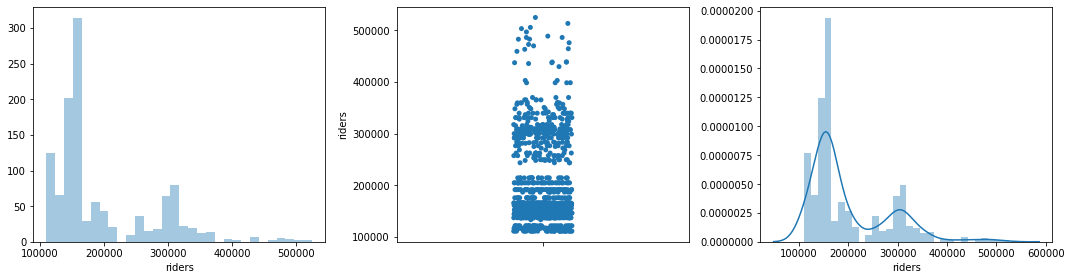

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,4))

sns.distplot(a = nyc_stations.riders, hist=True, kde=False, norm_hist=False, ax=ax1, bins=30)
sns.stripplot(x='riders',data=nyc_stations, jitter=True, orient='v', ax=ax2)
sns.distplot(a = nyc_stations.riders, hist=True, kde=True, ax=ax3, bins=30)

plt.tight_layout()

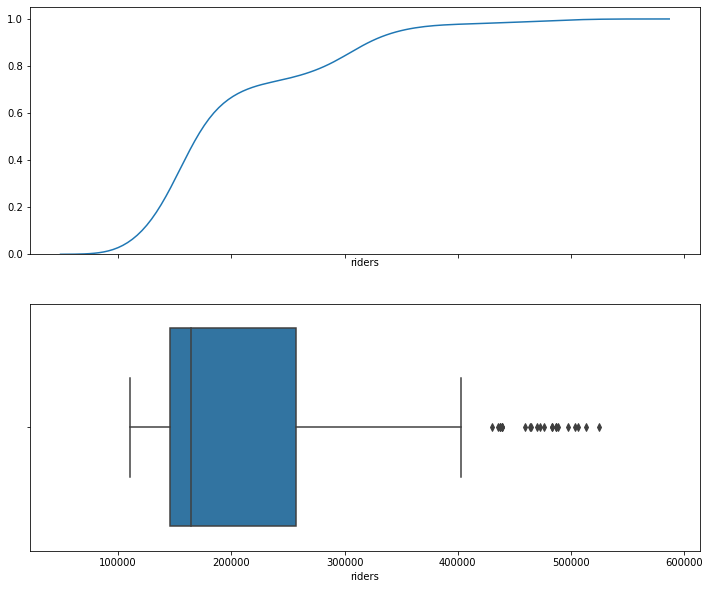

In [94]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, figsize=(12,10));

sns.distplot(a = nyc_stations.riders, hist=True, kde=True, ax=ax1, bins=30, kde_kws={'cumulative':True});
sns.boxplot(x='riders', data=nyc_stations, ax=ax2, orient='h');

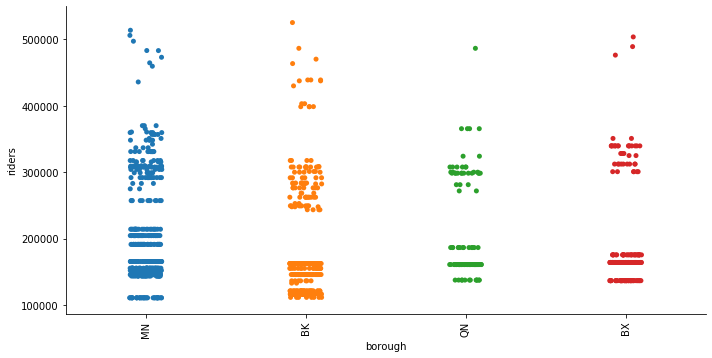

In [180]:
g = sns.catplot(x='borough', y='riders',data=nyc_stations, kind='strip', height=5, jitter=True, aspect=2, orient='v')
g.set_xticklabels(rotation=90);

From the two group of graphs we can see that the majority of stations, about 75%, serve between 100,000 and 250,000 people. There is another smaller group that serve between 250,000 and 350,000 people. 

#### **San Francisco People Served**

In [18]:
sanfran_stations = sanfran_voronoi.copy()
sanfran_stations.set_index('stationid', inplace=True)
sanfran_stations['riders'] = 0

for station in list(sanfran_stations.index):
    df = intersection(sanfran_voronoi[sanfran_voronoi.stationid==station], sanfran_hood_data) 
    sanfran_stations.loc[station,'riders'] = people_served(df, sanfran_hood_data)

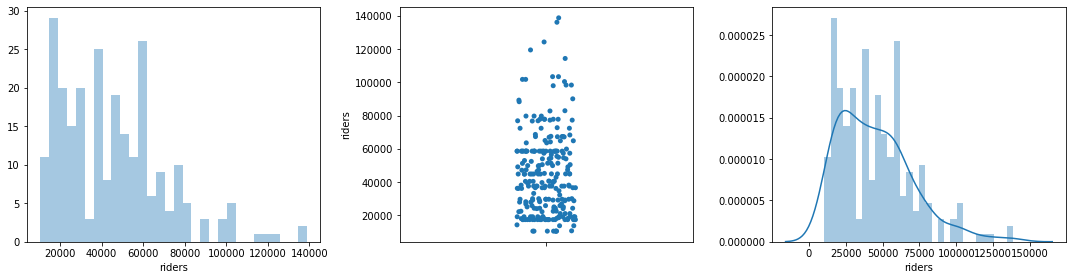

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,4))

sns.distplot(a = sanfran_stations.riders, hist=True, kde=False, norm_hist=False, ax=ax1, bins=30)
sns.stripplot(x='riders',data=sanfran_stations, jitter=True, orient='v', ax=ax2)
sns.distplot(a = sanfran_stations.riders, hist=True, kde=True, ax=ax3, bins=30)

plt.tight_layout()

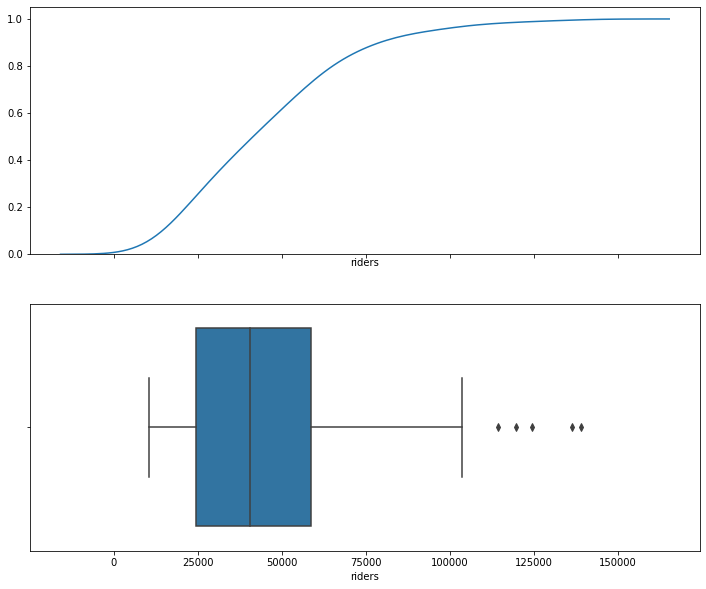

In [95]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, figsize=(12,10));

sns.distplot(a = sanfran_stations.riders, hist=True, kde=True, ax=ax1, bins=30, kde_kws={'cumulative':True});
sns.boxplot(x='riders', data=sanfran_stations, ax=ax2, orient='h');

In San Francisco the majority of stations serve between 10,000 and 60,000 people, again about 75% of people.

### **Step 6: People Served Ratio**

The 'people served' stastic on its own isn't very useful. It's difficult to tell if a station with a higher statistic has a bigger voronoi area or has a smaller voronoi area in a denser part of the city. A better statistic to look at would be the ratio between the riders served and the area of the voronoi

#### **New York Riders Ratios**

In [127]:
nyc_ratio = nyc_stations.merge(nyc_voronoi, left_index=True, on='stationid', how='left', suffixes=('_point', '_voronoi'))
nyc_ratio = gpd.GeoDataFrame(nyc_ratio)
nyc_ratio.set_index('stationid', inplace=True)

nyc_ratio['voronoi_area'] = nyc_ratio.geometry_voronoi.area
nyc_ratio['riders_per_sqm'] = nyc_ratio.riders/nyc_ratio.voronoi_area

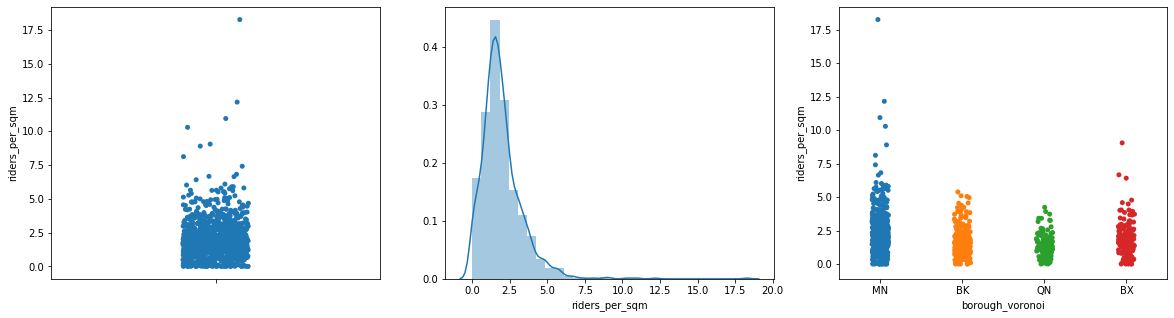

In [174]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,5))
sns.stripplot(y='riders_per_sqm',data=nyc_ratio, jitter=True, orient='v', ax=ax1)
sns.distplot(a=nyc_ratio.riders_per_sqm, hist=True, bins=30, ax=ax2)
sns.stripplot(x='borough_voronoi', y='riders_per_sqm', data=nyc_ratio, jitter=True, ax=ax3)

When we looked at just riders served the data was really spread out, the data is much tighter when looking at the ratio between the riders served and the area of the voronoi. Regardless of the borough, regardless of the location, the number of people that a station serves is rarely over 3.5 people per square meter of it's voronoi. Which makes practical sense, because the denser the population of an area the more stations you need to accomodate the population. The more stations packed into one area, the smaller the voronoi area. Although, the area is small it is still serving tons of people. This leads me to believe that population density is an extremely important factor when a company chooses the number of and the locations of stations in a potential expansion area. 

**Project Expansion: This could be an interesting optimization problem where we are trying to find the number of and locations of a station in an area such that the ratio between people served and voronoi area is under 3.5 sq meters**

#### **San Francisco Riders Ratios**

In [165]:
sanfran_ratio = sanfran_stations.merge(sanfran_voronoi, left_index=True, on='stationid', how='left', suffixes=('_point', '_voronoi'))
sanfran_ratio = gpd.GeoDataFrame(sanfran_ratio)
sanfran_ratio.set_index('stationid', inplace=True)

sanfran_ratio['voronoi_area'] = sanfran_ratio.geometry_voronoi.area
sanfran_ratio['riders_per_sqm'] = sanfran_ratio.riders/sanfran_ratio.voronoi_area

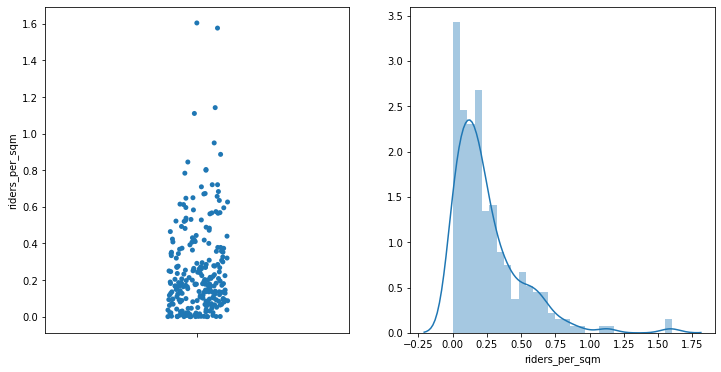

In [177]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.stripplot(y='riders_per_sqm',data=sanfran_ratio, jitter=True, orient='v', ax=ax1)
sns.distplot(a=sanfran_ratio.riders_per_sqm, hist=True, bins=30, ax=ax2)

Looking at the ratio between the riders and the area of the voronoi for San Francisco, the number of people that a station is rarely over 0.5 people per square meter of it's voronoi. 

**Project Expansion: We looked at how many people a station serves, but not every person uses the bike service. Could we determine how many actual riders are out of the total people a station serves.**

#### **Just for Fun: A Golden Rule?**

New York is bigger and more dense than San Francisco, so the ratio of people served per square meter of the voronoi will be larger. However, is there a 'golden rule' that can be used to determine what a location's ratio should be based on the its population. 

In [204]:
# Our previous queries used a subset of the neighborhoods
nyc_population_query = 'SELECT SUM(dem14) FROM neighborhoods.nyc_profile'
sanfran_population_query = 'SELECT SUM(population) FROM neighborhoods.sanfran_profile'

nyc_population = Queries.execute_query(conn, nyc_population_query, to_frame = True).values[0][0]
sanfran_population_query = Queries.execute_query(conn, sanfran_population_query, to_frame = True).values[0][0]

In [206]:
nyc_population / sanfran_population_query

10.757151511551939

The population of NYC is about 10.8 times bigger than the population of San Francisco. Is the median riders_per_sqm value also about 10.8 times bigger for NYC than it is for San Francisco?

In [211]:
nyc_ratio.riders_per_sqm.quantile(0.50) / sanfran_ratio.riders_per_sqm.quantile(0.50)

9.633302688705212

It's close, but this was a very quick very 'sloppy' analysis just for fun and nothing definitive can be said. However, it is an idea that might be worth looking into. Possibly another **Project Expansion**
<hr>

## **Would You Have Bike Access?**
What is the probability that a randomly selected New Yorker or San Franciscan lives within a certain distance of a station? We are going to pick a random person from the city, represented as a point. We will then create a buffer around the point and see if there are any stations within that buffer. For New York City we do this process with citibike stations AND  with MTA Subway Entrances and see how they compare. For San Francisco we will only use the BayWheels stations. 

### **Step 1: Gathering all the Neighborhood Data**
Although we already have half of the needed neighborhood data from the previous section, let's regather everything in this section so that it is clear. 
- We are going to call the neighborhood df that has all the neighborhoods of NYC **nyc_hood_data_A**. 
- We are going to call the neighborhood df that only has neighborhoods that have stations **nyc_hood_data_S**. 
- We are going to call the neighborhood df that has all the neighborhoods of San Francisco **sanfran_hood_data_A**.
- We are going to call the neighborhood df that only has neighborhoods that have stations **sanfran_hood_data_S**.

#### **NYC Neighborhoods**

In [306]:
nyc_hood_data_A_query = """
        SELECT 
          hood_info.hoodname, 
          hood_data.dem14 AS population, 
          hood_info.geometry
        FROM neighborhoods.nyc_hood AS hood_info
        LEFT JOIN neighborhoods.nyc_profile AS hood_data
          USING (code);
        """

nyc_hood_data_A= gpd.read_postgis(nyc_hood_data_A_query, conn, geom_col='geometry')
nyc_hood_data_A.to_crs(32118,inplace=True)
nyc_hood_data_A.set_index('hoodname', inplace=True)

In [307]:
nyc_hood_data_S_query = """
        SELECT 
          DISTINCT(hoodname), 
          hood_data.dem14 AS population, 
          hood_info.geometry
        FROM neighborhoods.nyc_hood AS hood_info
        LEFT JOIN neighborhoods.nyc_profile AS hood_data
          USING (code)
        INNER JOIN stations.citi_station AS stations
          ON ST_CONTAINS(hood_info.geometry::geometry, stations.geometry::geometry);
        """

nyc_hood_data_S= gpd.read_postgis(nyc_hood_data_S_query, conn, geom_col='geometry')
nyc_hood_data_S.to_crs(32118,inplace=True)
nyc_hood_data_S.set_index('hoodname', inplace=True)

#### **San Francisco Neighborhoods**

In [308]:
sanfran_hood_data_A_query = """
        SELECT * 
        FROM neighborhoods.sanfran_profile
        LEFT JOIN neighborhoods.sanfran_hood
          USING (hoodname);
        """

sanfran_hood_data_A = gpd.read_postgis(sanfran_hood_data_A_query, conn, geom_col='geometry')
sanfran_hood_data_A.to_crs(7131, inplace=True)
sanfran_hood_data_A.set_index('hoodname', inplace=True)

In [309]:
sanfran_hood_data_S_query = """
        SELECT 
          DISTINCT(hoodname), 
          hood_data.population, 
          hood_info.geometry
        FROM neighborhoods.sanfran_hood AS hood_info
        LEFT JOIN neighborhoods.sanfran_profile AS hood_data
          USING (hoodname)
        INNER JOIN stations.bay_station AS stations
          ON ST_CONTAINS(hood_info.geometry::geometry, stations.geometry::geometry);
        """
sanfran_hood_data_S = gpd.read_postgis(sanfran_hood_data_S_query, conn, geom_col='geometry')
sanfran_hood_data_S.to_crs(7131, inplace=True)
sanfran_hood_data_S.set_index('hoodname', inplace=True)

### **Step 2: Gather the Different Transit Data**

In [310]:
nyc_station_query = """
        SELECT geometry
        FROM stations.citi_station 
        WHERE 
          death IS NULL;
        """

nyc_stations = gpd.read_postgis(nyc_station_query, conn, geom_col='geometry')
nyc_stations.to_crs(32118,inplace=True);
nyc_stations = nyc_stations.geometry # Conver to GeoSeries

In [311]:
geofile = "s3://williams-citibike/MTA-Subway-Entrances.geojson"

with fs.open(geofile, 'rb') as file:
    subway = gpd.read_file(file)

subway.to_crs(32118, inplace=True)
subway = subway.geometry

In [312]:
sanfran_station_query = """
        SELECT geometry 
        FROM stations.bay_station
        WHERE 
          death IS NULL;
        """
sanfran_stations = gpd.read_postgis(sanfran_station_query, conn, geom_col='geometry')
sanfran_stations.to_crs(7131, inplace=True)
sanfran_stations = sanfran_stations.geometry

### **Step 2: The Probabilities of Choosing a Person**
The probabilitiy of picking someone in an area is not equal across all neighborhoods. The denser the neighborhood the more likely a random person will be picked from there. We need to come up with the probability that a person will be picked from a neighborhood based on the population. Additionally, these probabilities will be differnent depending on whether we choose to take the subset of neighborhoods or all the neighborhoods.

In [313]:
import random

#### **NYC Probabilities**

In [314]:
nyc_neighborhoods = [None]*2   # A two-length list of lists, the first list being the names of the neighborhoods in nyc_hood_data_A
nyc_probabilities = [None]*2   # A two-length list of lists, the second list being the probabilities of the neighborhoods in nyc_hood_data_S

In [315]:
total_pop = nyc_hood_data_A.population.sum()
nyc_neighborhoods[0] = list(nyc_hood_data_A.index)
nyc_probabilities[0] = list(nyc_hood_data_A.population / total_pop)

In [316]:
total_pop = nyc_hood_data_S.population.sum()
nyc_neighborhoods[1] = list(nyc_hood_data_S.index)
nyc_probabilities[1] = list(nyc_hood_data_S.population / total_pop)

#### **San Francisco Probabilites**

In [317]:
sanfran_neighborhoods = [None]*2   # A two-length list of lists, the first list being the names of the neighborhoods in sanfran_hood_data_A
sanfran_probabilities = [None]*2   # A two-length list of lists, the second list being the names of the neighborhoods in sanfran_hood_data_S

In [318]:
total_pop = sanfran_hood_data_A.population.sum()
sanfran_neighborhoods[0] = list(sanfran_hood_data_A.index)
sanfran_probabilities[0] = list(sanfran_hood_data_A.population / total_pop)

In [319]:
total_pop = sanfran_hood_data_S.population.sum()
sanfran_neighborhoods[1] = list(sanfran_hood_data_S.index)
sanfran_probabilities[1] = list(sanfran_hood_data_S.population / total_pop)

### **Step 3: Actually Choosing a Person**

In [320]:
def random_person(hood_data, neighborhoods: list, prob: list) -> shapely.geometry.Point():
    name = np.random.choice(neighborhoods, 1, prob)[0]   # First pick a random neighborhood
    poly = hood_data.loc[name,'geometry']
    minx, miny, maxx, maxy = poly.bounds   # Create a rectangular box around the polygon
    
    while True:
        p = shapely.geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))   # Pick a random point inside the bounds
        if poly.contains(p):   # Make sure the point selected is inside the polygon
            return p

### **Step 4: Check if there is a Station within a Radius**

In [321]:
def has_station(p: shapely.geometry.Point(), transit: list, radius: float=805):
    """ radius is in meters and the buffer uses the radius to create a circular area"""
    buf = p.buffer(radius)

    for location in transit:
        if buf.contains(location): 
            return True  
    
    return False

### **Step 5: Run the Experiments**

In [322]:
def trials(rounds: int, people_per_round: int, hood_data: pd.DataFrame, neighborhoods: list, prob: list, transit: gpd.GeoSeries() , radius: float=805):
    results = []

    for i in range(rounds): # The rounds of the experiment
        total = 0
        
        # The experiment is to pick 'per_round' people and see what percentage live near a station
        for j in range(people_per_round): 
            person = random_person(hood_data, neighborhoods, prob)
            total += has_station(person, transit, radius)
        
        total /= per_round
        results.append(total)
    
    return results

#### **NYC Experiments**

In [326]:
radius = [805,604,402,201,80]   # 80m is about a 1 minute walk
citiA = []   # nyc_hood_data_A, idx=0, nyc_stations
citiS = []   # nyc_hood_data_S, idx=1, nyc_stations
subwayA = []   # nyc_hood_data_A, idx=0, subway
subwayS = []   # nyc_hood_data_S, idx=1, subway

In [327]:
for r in radius:
     w = trials(100,100, nyc_hood_data_A, nyc_neighborhoods[0], nyc_probabilities[0], nyc_stations, r)
     citiA.append((r,np.mean(w)))

In [328]:
for r in radius:
    x = trials(100,100, nyc_hood_data_S, nyc_neighborhoods[1], nyc_probabilities[1], nyc_stations, r)
    citiS.append((r,np.mean(x)))

In [329]:
for r in radius:
    y = trials(100,100, nyc_hood_data_A, nyc_neighborhoods[0], nyc_probabilities[0], subway, r)
    subwayA.append((r,np.mean(y)))


In [331]:
for r in radius:
    z = trials(100,100, nyc_hood_data_S, nyc_neighborhoods[1], nyc_probabilities[1], subway, r)
    subwayS.append((r,np.mean(z)))

The four different combinations of data and the five different distances used as a buffer are shown in the table below along with the results of the experiment.

<table>
    <tr> 
        <th rowspan=2;> Distances (miles) </th>
        <th colspan=2;> CitiBike</th>
        <th colspan=2;> Subway</th>
    </tr>
    <tr>
        <th style="text-align: center;">All Hoods</th>
        <th style="text-align: center;">Hoods w/ Stations</th>
        <th style="text-align: center;">All Hoods</th>
        <th style="text-align: center;">Hoods w/ Stations</th>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.5 (805m)</td>
        <td style="text-align: center;">41%</td>
        <td style="text-align: center;">83%</td>
        <td style="text-align: center;">67%</td>
        <td style="text-align: center;">85%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.375 (604m)</td>
        <td style="text-align: center;">39%</td>
        <td style="text-align: center;">80%</td>
        <td style="text-align: center;">58%</td>
        <td style="text-align: center;">76%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.25 (402m) </td>
        <td style="text-align: center;">36%</td>
        <td style="text-align: center;">76%</td>
        <td style="text-align: center;">43%</td>
        <td style="text-align: center;">59%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.125 (201m)</td>
        <td style="text-align: center;">28%</td>
        <td style="text-align: center;">59%</td>
        <td style="text-align: center;">17%</td>
        <td style="text-align: center;">26%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.05 (80m) </td>
        <td style="text-align: center;">6%</td>
        <td style="text-align: center;">15%</td>
        <td style="text-align: center;">4%</td>
        <td style="text-align: center;">6%</td>
    </tr>
    

</table>

<p style="text-align:center"> <b>Observations</b> </p>
<ol>
    <li style="margin:10px 0">When it comes to the subset of neighborhoods that have stations, CitiBike outperforms the subway in terms of accessibility. On the flip side, in terms of all neighborhoods the subway does better. If MTA bus stations were included, I believe that the MTA as a wole would completely dominate citibike in all categories and distances
    <li style="margin:10px 0"> When all neighborhoods are included, the percent of people that have access to CitiBike is cut in half for all distances. Whereas the drop for the subway stations isn't as sharp. This tells me that the distribution of CitiBikes is concentrated in a 'small' number of neighborhoods. When we added non-station neighborhoods back into our 'neighborhood set' there were so many of them (neighborhoods) that they caused the probability to drop significantly.
    <li> It's very rare to live within a 1 minute walk from any transit service, let alone both. 
</ol>

**Project Expansion: Include the MTA Bus Information in the subway calculations**

#### **San Francisco Experiments**

In [332]:
radius = [805,604,402,201,80]
bayA = []   # sanfran_hood_data_A, idx=0, sanfran_stations
bayS = []   # sanfran_hood_data_S, idx=1, sanfran_stations

In [341]:
for r in radius:
     w = trials(100,100, sanfran_hood_data_A, sanfran_neighborhoods[0], sanfran_probabilities[0], sanfran_stations, r)
     bayA.append((r,np.mean(w)))

In [334]:
for r in radius:
    x = trials(100,100, sanfran_hood_data_S, sanfran_neighborhoods[1], sanfran_probabilities[1], sanfran_stations, r)
    bayS.append((r,np.mean(x)))

The two different combinations of data and the five different distances used as a buffer are shown in the table below along with the results of the experiment.

<table>
    <tr> 
        <th rowspan=2;> Distances (miles) </th>
        <th colspan=2;> BayWheels</th>
    </tr>
    <tr>
        <th style="text-align: center;">All Hoods</th>
        <th style="text-align: center;">Hoods w/ Stations</th>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.5 (805m)</td>
        <td style="text-align: center;">73%</td>
        <td style="text-align: center;">88%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.375 (604m)</td>
        <td style="text-align: center;">65%</td>
        <td style="text-align: center;">80%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.25 (402m) </td>
        <td style="text-align: center;">53%</td>
        <td style="text-align: center;">65%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.125 (201m)</td>
        <td style="text-align: center;">28%</td>
        <td style="text-align: center;">36%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.05 (80m) </td>
        <td style="text-align: center;">6%</td>
        <td style="text-align: center;">7%</td>
    </tr>
    

</table>

<p style="text-align:center"> <b>Observations</b> </p>
<ol>
    <li style="margin:10px 0"> The BayWheels stations of San Francisco are more spread throughout the neighborhoods than the CitiBike stations of NYC. The drop in probability between the two sets of neighborhoods is less sharp (they are only about 10% away from each other).
    <li> For the neighborhoods that have stations, at the lower distances CitiBike is more accessible. I believe that this is because CitiBike concentrates more stations to neighborhoods with higher densities. The more dense a neighborhood, the more stations, and the more likely a person will be randomly picked from those neighborhoods.
</ol>

<div style="line-height:11px">
    <p style="text-align:right;font-style:italic;"> Data Science = Solving Problems = Happiness </p>
    <p style="text-align:right"> Denzel S. Williams </p>
</div>